# Titanic Competition - Model - Ramin F.

in this notebook we are going to develope a machine learning model for titanic competition. for this purpose we are going to test multiple approaches and algorithms to investigate which one will have the most accuracy.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import pickle
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('darkgrid')

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Droping unwanted features

there are some useless features for ML models, in this section we are going to drop them.

In [4]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_cat = train

# Making Categorical Variables Continious (One-Hot) | and label encoding for train_cat
there are some categorical variables in dataset, i.e. "Pclass", "Sex" and "Embarked". in order to make this features usable by ML models we must make them continious. we are going to use one-hot encoding approach for this matter.

In [5]:
dummy_pclass = pd.get_dummies(train['Pclass'], prefix='Pclass')
dummy_sex = pd.get_dummies(train['Sex'], prefix='Sex')
dummy_embarked = pd.get_dummies(train['Embarked'], prefix='Embarked')
train = pd.concat([train, dummy_pclass, dummy_sex, dummy_embarked], axis=1)
train.drop(['Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)
train

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.00,1,0,7.25,0,0,1,0,1,0,0,1
1,1,38.00,1,0,71.28,1,0,0,1,0,1,0,0
2,1,26.00,0,0,7.92,0,0,1,1,0,0,0,1
3,1,35.00,1,0,53.10,1,0,0,1,0,0,0,1
4,0,35.00,0,0,8.05,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.00,0,0,13.00,0,1,0,0,1,0,0,1
887,1,19.00,0,0,30.00,1,0,0,1,0,0,0,1
888,0,NaN,1,2,23.45,0,0,1,1,0,0,0,1
889,1,26.00,0,0,30.00,1,0,0,0,1,1,0,0


In [6]:
labels, _ = pd.factorize(train_cat['Sex'])
train_cat['Sex'] = labels.tolist()
labels, _ = pd.factorize(train_cat['Embarked'])
train_cat['Embarked'] = labels.tolist()

# Treating Missing Values Problem

as we saw in the EDA notebook, some records have missing values. to be more specific, in "Age" feature we have 177 records with missing data and 3 records with missing data in "Embarked" Features. the "Cabin" feature also has some missing values but since we will going to drop that feature, there is no need for imputing that feature.

In [7]:
train.isnull().sum()

Survived        0
Age           177
SibSp           0
Parch           0
Fare            0
Pclass_1        0
Pclass_2        0
Pclass_3        0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [9]:
train_imputation_matrix = train.values
imp = IterativeImputer(max_iter = 10)
predicted_imp = np.round(imp.fit_transform(train_imputation_matrix))

In [10]:
train_imputed = pd.DataFrame(predicted_imp, columns=['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
                                                     'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'])

train = train.merge(train_imputed, on=train.index.values, how='left')
train.drop(['key_0', 'Survived_x', 'Age_x', 'SibSp_x', 'Parch_x', 'Fare_x', 'Pclass_1_x', 'Pclass_2_x', 'Pclass_3_x',
            'Sex_female_x', 'Sex_male_x', 'Embarked_C_x', 'Embarked_Q_x', 'Embarked_S_x'], axis=1, inplace=True)
train.rename(columns={'Survived_y': 'Survived',
                      'Age_y': 'Age',
                      'SibSp_y': 'SibSp',
                      'Parch_y': 'Parch',
                      'Fare_y': 'Fare',
                      'Pclass_1_y': 'Pclass_1',
                      'Pclass_2_y': 'Pclass_2',
                      'Pclass_3_y': 'Pclass_3',
                      'Sex_female_y': 'Sex_female',
                      'Sex_male_y': 'Sex_male',
                      'Embarked_C_y': 'Embarked_C',
                      'Embarked_Q_y': 'Embarked_Q',
                      'Embarked_S_y': 'Embarked_S'}, inplace=True)
train

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.00,22.00,1.00,0.00,7.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
1,1.00,38.00,1.00,0.00,71.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2,1.00,26.00,0.00,0.00,8.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
3,1.00,35.00,1.00,0.00,53.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
4,0.00,35.00,0.00,0.00,8.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.00,27.00,0.00,0.00,13.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
887,1.00,19.00,0.00,0.00,30.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
888,0.00,24.00,1.00,2.00,23.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00
889,1.00,26.00,0.00,0.00,30.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00


In [11]:
train_cat = train_cat.merge(train['Age'], on=train.index.values, how='left')
train_cat.drop(columns=['key_0', 'Age_x'], inplace=True)
train_cat.rename(columns={'Age_y': 'Age'}, inplace=True)
train_cat

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age
0,0,3,0,1,0,7.25,0,22.00
1,1,1,1,1,0,71.28,1,38.00
2,1,3,1,0,0,7.92,0,26.00
3,1,1,1,1,0,53.10,0,35.00
4,0,3,0,0,0,8.05,0,35.00
...,...,...,...,...,...,...,...,...
886,0,2,0,0,0,13.00,0,27.00
887,1,1,1,0,0,30.00,0,19.00
888,0,3,1,1,2,23.45,0,24.00
889,1,1,0,0,0,30.00,1,26.00


In [12]:
train.isnull().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

as you can see in the cell above all of the 177 records with missing values in "Age" feature had been imputed.

# Splitting Dependent and Independent Variables
next step we have to do is splitting the dependent and independent variables from together. in this project dependent variable is "Survived" feature.

In [13]:
Y = np.asarray(train['Survived'])
X = np.asarray(train.loc[:, ~ train.columns.isin(['Survived'])])
X_cat = np.asarray(train_cat.loc[:, ~ train_cat.columns.isin(['Survived'])])
print(f'dependent variable matrix shape: {Y.shape}')
print(f'independent variables matrix shape: {X.shape}')

dependent variable matrix shape: (891,)
independent variables matrix shape: (891, 12)


In [17]:
X_train,X_valid,y_train,y_valid=train_test_split(X,Y,test_size=0.2, stratify=Y)
X_train_cat,X_valid_cat,y_train_cat,y_valid_cat=train_test_split(X_cat,Y,test_size=0.2, stratify=Y)

# PCA for Demonstrating datapoints in 2-Dimension

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print(f'original shape: {X.shape}.')
print(f'transformed shape: {X_pca.shape}.')

original shape: (891, 12).
transformed shape: (891, 2).


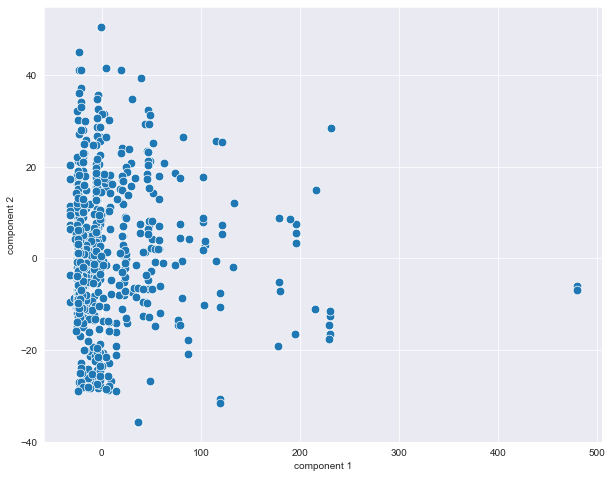

In [40]:
plt.figure(figsize = (10, 8))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1],s=75)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

params = {'fit_intercept': [True, False],    
        'C': [1, .5, .25, .1, .05, .025, .01, .005, .0025, .001]}

grid = GridSearchCV(LogisticRegression(), param_grid=params, return_train_score=True, verbose=3)
grid.fit(X_train, y_train)
print('\n', f'{grid.best_estimator_} best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=1, fit_intercept=True;, score=(train=0.821, test=0.881) total time=   0.0s
[CV 2/5] END C=1, fit_intercept=True;, score=(train=0.828, test=0.839) total time=   0.0s
[CV 3/5] END C=1, fit_intercept=True;, score=(train=0.826, test=0.824) total time=   0.0s
[CV 4/5] END C=1, fit_intercept=True;, score=(train=0.844, test=0.775) total time=   0.0s
[CV 5/5] END C=1, fit_intercept=True;, score=(train=0.844, test=0.782) total time=   0.0s
[CV 1/5] END C=1, fit_intercept=False;, score=(train=0.815, test=0.874) total time=   0.0s
[CV 2/5] END C=1, fit_intercept=False;, score=(train=0.824, test=0.839) total time=   0.0s
[CV 3/5] END C=1, fit_intercept=False;, score=(train=0.828, test=0.824) total time=   0.0s
[CV 4/5] END C=1, fit_intercept=False;, score=(train=0.842, test=0.775) total time=   0.0s
[CV 5/5] END C=1, fit_intercept=False;, score=(train=0.844, test=0.775) total time=   0.0s
[CV 1/5] END C=0.5, fit_intercept

as you can see above the best model with optimum hyperparameters achieved 0.81 Accuracy.

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       110
         1.0       0.78      0.61      0.68        69

    accuracy                           0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179



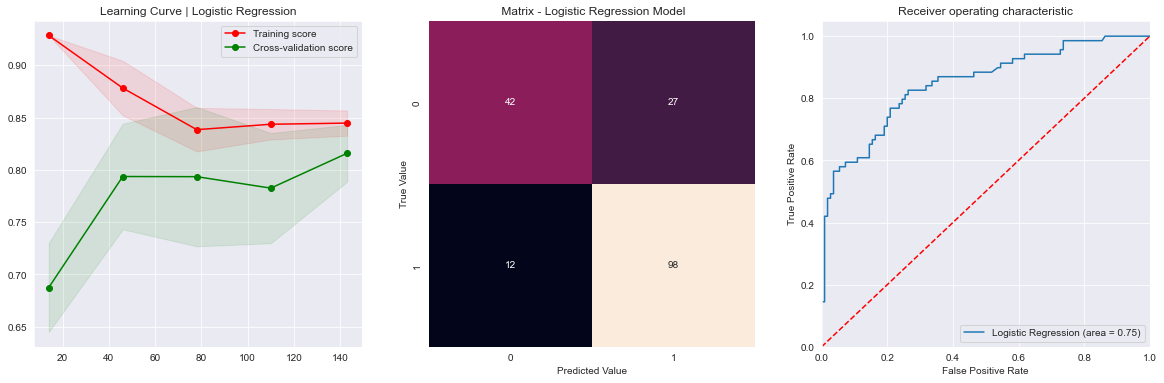

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(LogisticRegression(), X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc='best')
axes[0].set_title('Learning Curve | Logistic Regression')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title(' Matrix - Logistic Regression Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

in the graph above you can see the Learning curve, Confusion matrix and ROC Curve for the most optimum model of logistic regression, 

# K-Nearest Neighbor

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [57]:
params = {
    'n_neighbors': np.arange(2,16,1),
    'weights': ['uniform', 'distance']
}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, return_train_score=True, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END n_neighbors=2, weights=uniform;, score=(train=0.851, test=0.741) total time=   0.0s
[CV 2/5] END n_neighbors=2, weights=uniform;, score=(train=0.865, test=0.671) total time=   0.0s
[CV 3/5] END n_neighbors=2, weights=uniform;, score=(train=0.832, test=0.746) total time=   0.0s
[CV 4/5] END n_neighbors=2, weights=uniform;, score=(train=0.856, test=0.732) total time=   0.0s
[CV 5/5] END n_neighbors=2, weights=uniform;, score=(train=0.854, test=0.718) total time=   0.0s
[CV 1/5] END n_neighbors=2, weights=distance;, score=(train=0.981, test=0.748) total time=   0.0s
[CV 2/5] END n_neighbors=2, weights=distance;, score=(train=0.986, test=0.692) total time=   0.0s
[CV 3/5] END n_neighbors=2, weights=distance;, score=(train=0.975, test=0.775) total time=   0.0s
[CV 4/5] END n_neighbors=2, weights=distance;, score=(train=0.981, test=0.711) total time=   0.0s
[CV 5/5] END n_neighbors=2, weights=distance;, score=(train=0

              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78       110
         1.0       0.65      0.52      0.58        69

    accuracy                           0.71       179
   macro avg       0.69      0.67      0.68       179
weighted avg       0.70      0.71      0.70       179



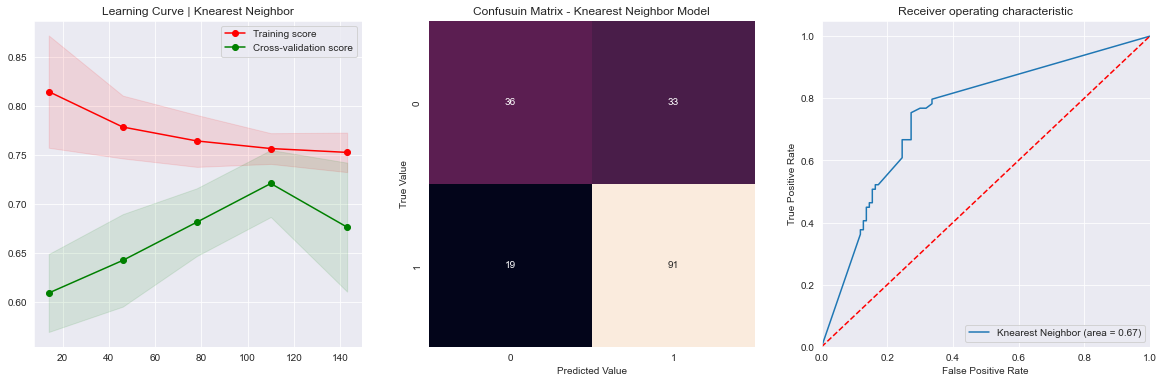

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(KNeighborsClassifier(), X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | Knearest Neighbor')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - Knearest Neighbor Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='Knearest Neighbor (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

in the graph above you can see the Learning curve, Confusion matrix and ROC Curve for the most optimum model of logistic regression, 

# Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params, return_train_score=True, cv=6, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 6 folds for each of 4 candidates, totalling 24 fits
[CV 1/6] END criterion=gini, splitter=best;, score=(train=0.981, test=0.807) total time=   0.0s
[CV 2/6] END criterion=gini, splitter=best;, score=(train=0.981, test=0.773) total time=   0.0s
[CV 3/6] END criterion=gini, splitter=best;, score=(train=0.980, test=0.756) total time=   0.0s
[CV 4/6] END criterion=gini, splitter=best;, score=(train=0.980, test=0.714) total time=   0.0s
[CV 5/6] END criterion=gini, splitter=best;, score=(train=0.983, test=0.771) total time=   0.0s
[CV 6/6] END criterion=gini, splitter=best;, score=(train=0.980, test=0.805) total time=   0.0s
[CV 1/6] END criterion=gini, splitter=random;, score=(train=0.981, test=0.773) total time=   0.0s
[CV 2/6] END criterion=gini, splitter=random;, score=(train=0.981, test=0.748) total time=   0.0s
[CV 3/6] END criterion=gini, splitter=random;, score=(train=0.980, test=0.765) total time=   0.0s
[CV 4/6] END criterion=gini, splitter=random;, score=(train=0.980, tes

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82       110
         1.0       0.72      0.68      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.78       179



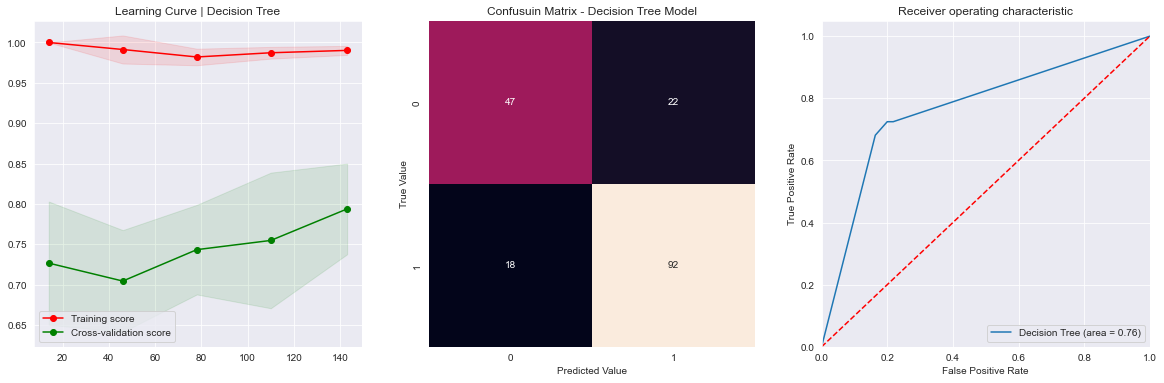

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(DecisionTreeClassifier(), X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | Decision Tree')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - Decision Tree Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

in the graph above you can see the Learning curve, Confusion matrix and ROC Curve for the most optimum model of Decision Tree.

# Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
model = RandomForestClassifier(n_estimators=1300, criterion='entropy', min_samples_split=4, bootstrap=True)

In [64]:
params = {
    'max_depth': np.arange(2, 15, 1)
    }
grid = GridSearchCV(model, param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5] END ...max_depth=2;, score=(train=0.789, test=0.839) total time=   2.2s
[CV 2/5] END ...max_depth=2;, score=(train=0.805, test=0.748) total time=   2.3s
[CV 3/5] END ...max_depth=2;, score=(train=0.802, test=0.761) total time=   2.0s
[CV 4/5] END ...max_depth=2;, score=(train=0.791, test=0.803) total time=   1.8s
[CV 5/5] END ...max_depth=2;, score=(train=0.788, test=0.831) total time=   2.1s
[CV 1/5] END ...max_depth=3;, score=(train=0.826, test=0.846) total time=   2.1s
[CV 2/5] END ...max_depth=3;, score=(train=0.826, test=0.755) total time=   2.2s
[CV 3/5] END ...max_depth=3;, score=(train=0.826, test=0.768) total time=   2.2s
[CV 4/5] END ...max_depth=3;, score=(train=0.818, test=0.824) total time=   2.3s
[CV 5/5] END ...max_depth=3;, score=(train=0.818, test=0.838) total time=   2.0s
[CV 1/5] END ...max_depth=4;, score=(train=0.835, test=0.853) total time=   2.3s
[CV 2/5] END ...max_depth=4;, score=(train=0.831

              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88       110
         1.0       0.85      0.74      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



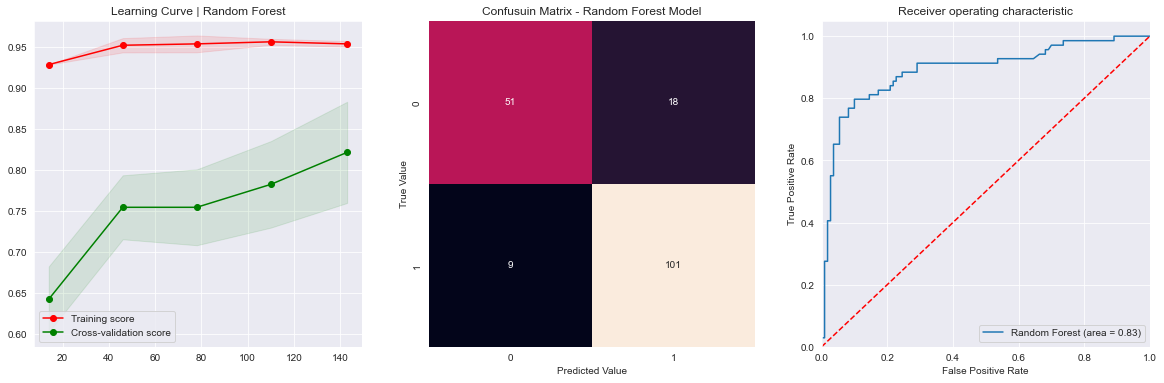

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(grid.best_estimator_, X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | Random Forest')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - Random Forest Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

in the graph above you can see the Learning curve, Confusion matrix and ROC Curve for the most optimum model of Decision Tree.

# XGBoost

In [66]:
from xgboost import XGBClassifier

In [67]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': np.arange(0.3, 1, 0.3),
    'subsample': np.arange(0.25,1.25,0.25),
    'refresh_leaf': [0, 1]
    }
grid = GridSearchCV(XGBClassifier(eval_metric='error'), param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END booster=gbtree, eta=0.3, refresh_leaf=0, subsample=0.25;, score=(train=0.905, test=0.811) total time=   0.0s
[CV 2/5] END booster=gbtree, eta=0.3, refresh_leaf=0, subsample=0.25;, score=(train=0.921, test=0.776) total time=   0.0s
[CV 3/5] END booster=gbtree, eta=0.3, refresh_leaf=0, subsample=0.25;, score=(train=0.905, test=0.768) total time=   0.0s
[CV 4/5] END booster=gbtree, eta=0.3, refresh_leaf=0, subsample=0.25;, score=(train=0.916, test=0.859) total time=   0.0s
[CV 5/5] END booster=gbtree, eta=0.3, refresh_leaf=0, subsample=0.25;, score=(train=0.902, test=0.817) total time=   0.0s
[CV 1/5] END booster=gbtree, eta=0.3, refresh_leaf=0, subsample=0.5;, score=(train=0.953, test=0.839) total time=   0.0s
[CV 2/5] END booster=gbtree, eta=0.3, refresh_leaf=0, subsample=0.5;, score=(train=0.965, test=0.776) total time=   0.0s
[CV 3/5] END booster=gbtree, eta=0.3, refresh_leaf=0, subsample=0.5;, score=(train=0.9

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       110
         1.0       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



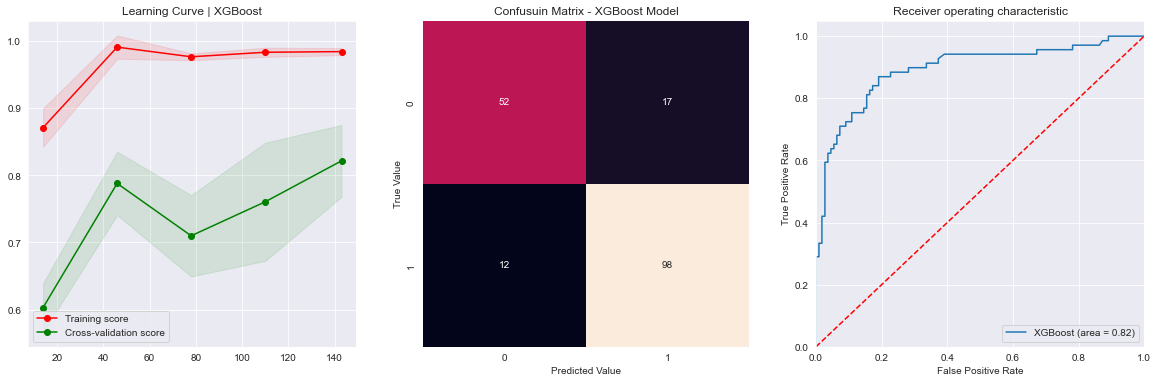

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(XGBClassifier(eval_metric='error'), X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | XGBoost')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - XGBoost Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='XGBoost (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

# Light GBM

In [19]:
from lightgbm import LGBMClassifier

In [143]:
params = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': np.arange(20, 120, 20, np.int16),
    'n_estimators': np.arange(1000, 1500, 100),
    'reg_lambda': np.arange(0.25, 1.25, 0.25)
}
grid = GridSearchCV(LGBMClassifier(learning_rate=.3), param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END boosting_type=gbdt, n_estimators=1000, num_leaves=20, reg_lambda=0.25;, score=(train=0.980, test=0.752) total time=   1.3s
[CV 2/5] END boosting_type=gbdt, n_estimators=1000, num_leaves=20, reg_lambda=0.25;, score=(train=0.986, test=0.848) total time=   1.2s
[CV 3/5] END boosting_type=gbdt, n_estimators=1000, num_leaves=20, reg_lambda=0.25;, score=(train=0.982, test=0.720) total time=   1.5s
[CV 4/5] END boosting_type=gbdt, n_estimators=1000, num_leaves=20, reg_lambda=0.25;, score=(train=0.982, test=0.774) total time=   0.7s
[CV 5/5] END boosting_type=gbdt, n_estimators=1000, num_leaves=20, reg_lambda=0.25;, score=(train=0.978, test=0.871) total time=   0.7s
[CV 1/5] END boosting_type=gbdt, n_estimators=1000, num_leaves=20, reg_lambda=0.5;, score=(train=0.980, test=0.768) total time=   0.7s
[CV 2/5] END boosting_type=gbdt, n_estimators=1000, num_leaves=20, reg_lambda=0.5;, score=(train=0.986, test=0.840) total

In [146]:
# saving this version of model
filename = f'Light GBM v1.0.pkl'
pickle.dump(grid,open(f'{filename}', 'wb'))
print(f'Model {filename} saved successfully!')

Model Light GBM v1.0.pkl saved successfully!


In [199]:
grid = pickle.load(open('Light GBM v1.0.pkl', 'rb'))

LGBMClassifier(boosting_type='dart', learning_rate=0.3, n_estimators=1000,
               num_leaves=40, reg_lambda=0.75)

              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       159
         1.0       0.77      0.77      0.77       109

    accuracy                           0.81       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.81      0.81      0.81       268



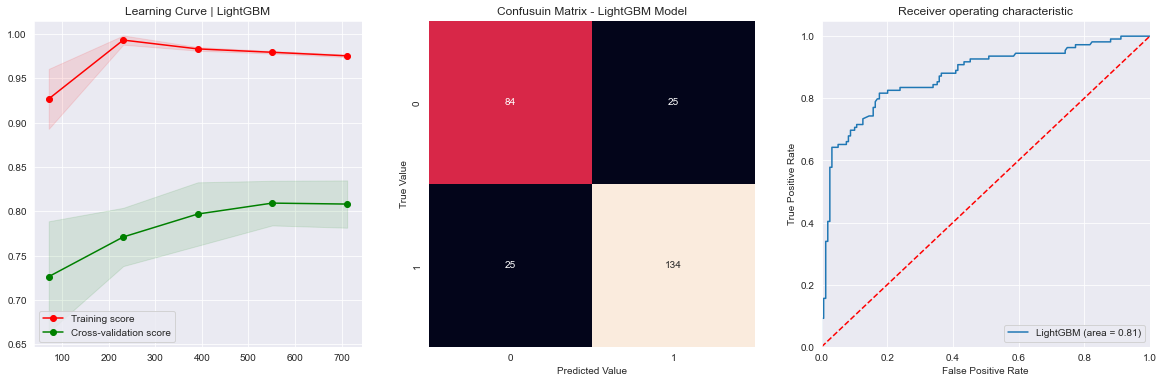

In [200]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(grid.best_estimator_, X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | LightGBM')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - LightGBM Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='LightGBM (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

In [151]:
model = LGBMClassifier(boosting_type='dart', learning_rate=0.3, n_estimators=1000, num_leaves=40, reg_lambda=0.75, objective='binary')

In [154]:
params = {
    'max_depth': np.arange(2, 11, 1),
    # 'min_data_in_leaf': np.arange(30, 55, 5),
    'extra_trees': [True, False],
    # 'max_bin': np.arange(50, 300, 50),
    'reg_alpha': np.arange(0.25, 1.25, 0.25)
}
grid = GridSearchCV(model, param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} best hyperparameters are: {grid.best_params_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END extra_trees=True, max_depth=2, reg_alpha=0.25;, score=(train=0.882, test=0.832) total time=   2.0s
[CV 2/5] END extra_trees=True, max_depth=2, reg_alpha=0.25;, score=(train=0.886, test=0.856) total time=   1.5s
[CV 3/5] END extra_trees=True, max_depth=2, reg_alpha=0.25;, score=(train=0.902, test=0.808) total time=   1.4s
[CV 4/5] END extra_trees=True, max_depth=2, reg_alpha=0.25;, score=(train=0.902, test=0.798) total time=   1.7s
[CV 5/5] END extra_trees=True, max_depth=2, reg_alpha=0.25;, score=(train=0.874, test=0.879) total time=   1.4s
[CV 1/5] END extra_trees=True, max_depth=2, reg_alpha=0.5;, score=(train=0.869, test=0.832) total time=   1.5s
[CV 2/5] END extra_trees=True, max_depth=2, reg_alpha=0.5;, score=(train=0.871, test=0.864) total time=   1.5s
[CV 3/5] END extra_trees=True, max_depth=2, reg_alpha=0.5;, score=(train=0.886, test=0.792) total time=   1.4s
[CV 4/5] END extra_trees=True, max_depth=2, r

In [156]:
# saving this version of model
filename = f'Light GBM v2.0.pkl'
pickle.dump(grid,open(f'{filename}', 'wb'))
print(f'Model {filename} saved successfully!')

Model Light GBM v2.0.pkl saved successfully!


In [201]:
grid = pickle.load(open('Light GBM v2.0.pkl', 'rb'))
grid.best_estimator_

LGBMClassifier(boosting_type='dart', extra_trees=False, learning_rate=0.3,
               max_depth=2, n_estimators=1000, num_leaves=40,
               objective='binary', reg_alpha=0.25, reg_lambda=0.75)

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       159
         1.0       0.85      0.74      0.79       109

    accuracy                           0.84       268
   macro avg       0.85      0.83      0.83       268
weighted avg       0.84      0.84      0.84       268



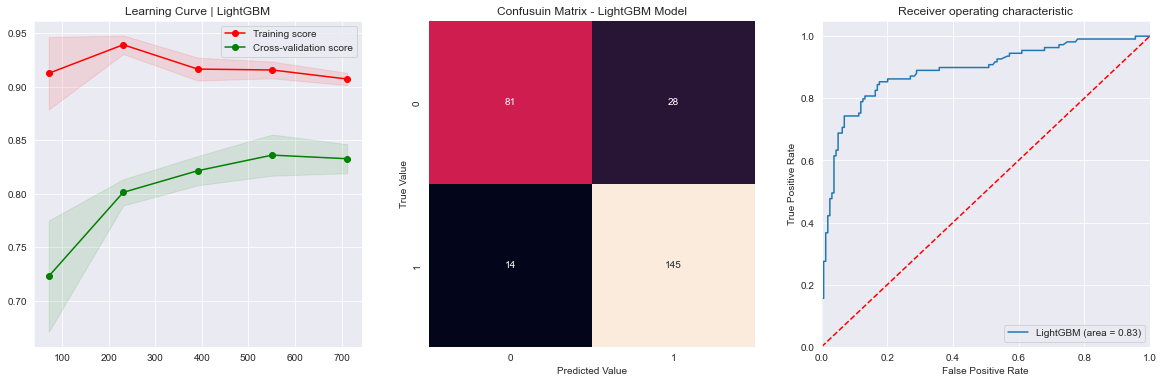

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(grid.best_estimator_, X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | LightGBM')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - LightGBM Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='LightGBM (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

In [159]:
model = LGBMClassifier(boosting_type='dart', extra_trees=False, learning_rate=0.3, max_depth=2, n_estimators=1000, num_leaves=40,
                       objective='binary', reg_alpha=0.25, reg_lambda=0.75)

In [161]:
params = {
    'min_child_samples': np.arange(30, 55, 5),
    'max_bin': np.arange(50, 300, 50)
}
grid = GridSearchCV(model, param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END max_bin=50, min_child_samples=30;, score=(train=0.894, test=0.856) total time=   1.9s
[CV 2/5] END max_bin=50, min_child_samples=30;, score=(train=0.908, test=0.848) total time=   1.4s
[CV 3/5] END max_bin=50, min_child_samples=30;, score=(train=0.916, test=0.792) total time=   1.4s
[CV 4/5] END max_bin=50, min_child_samples=30;, score=(train=0.910, test=0.798) total time=   1.7s
[CV 5/5] END max_bin=50, min_child_samples=30;, score=(train=0.898, test=0.887) total time=   1.7s
[CV 1/5] END max_bin=50, min_child_samples=35;, score=(train=0.882, test=0.824) total time=   1.4s
[CV 2/5] END max_bin=50, min_child_samples=35;, score=(train=0.896, test=0.832) total time=   1.6s
[CV 3/5] END max_bin=50, min_child_samples=35;, score=(train=0.914, test=0.800) total time=   1.7s
[CV 4/5] END max_bin=50, min_child_samples=35;, score=(train=0.908, test=0.806) total time=   1.8s
[CV 5/5] END max_bin=50, min_child_samples=35;,

In [162]:
# saving this version of model
filename = f'Light GBM v3.0.pkl'
pickle.dump(grid,open(f'{filename}', 'wb'))
print(f'Model {filename} saved successfully!')

Model Light GBM v3.0.pkl saved successfully!


In [203]:
grid = pickle.load(open('Light GBM v3.0.pkl', 'rb'))
grid.best_estimator_

LGBMClassifier(boosting_type='dart', extra_trees=False, learning_rate=0.3,
               max_bin=100, max_depth=2, min_child_samples=30,
               n_estimators=1000, num_leaves=40, objective='binary',
               reg_alpha=0.25, reg_lambda=0.75)

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       159
         1.0       0.86      0.75      0.80       109

    accuracy                           0.85       268
   macro avg       0.85      0.84      0.84       268
weighted avg       0.85      0.85      0.85       268



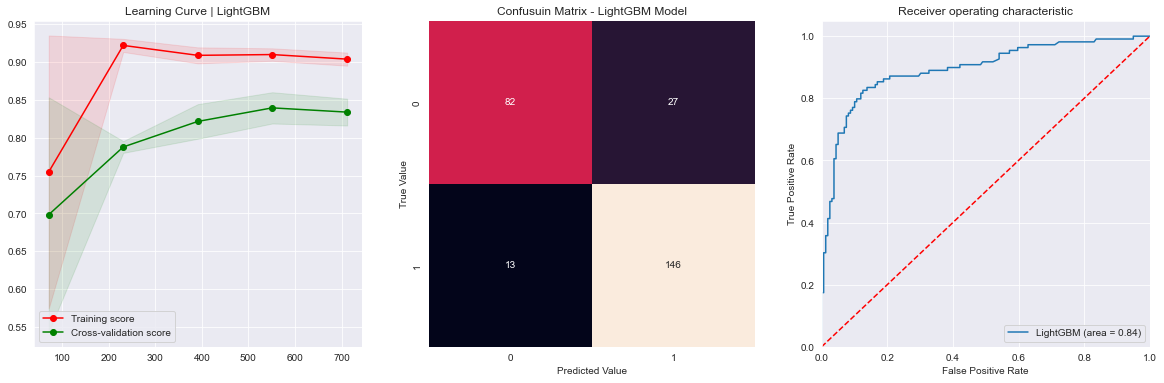

In [204]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(grid.best_estimator_, X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | LightGBM')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - LightGBM Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='LightGBM (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

In [207]:
model = LGBMClassifier(boosting_type='dart', extra_trees=False, learning_rate=0.3,
               max_bin=100, max_depth=2, min_child_samples=30, min_child_weight=.00001,
               n_estimators=1000, objective='binary',
               reg_alpha=0.25, reg_lambda=0.75)

In [208]:
params = {
    'num_leaves': np.arange(2, 5, 1)
}
grid = GridSearchCV(model, param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..num_leaves=2;, score=(train=0.823, test=0.816) total time=   1.3s
[CV 2/5] END ..num_leaves=2;, score=(train=0.827, test=0.848) total time=   0.9s
[CV 3/5] END ..num_leaves=2;, score=(train=0.851, test=0.792) total time=   1.0s
[CV 4/5] END ..num_leaves=2;, score=(train=0.856, test=0.806) total time=   1.1s
[CV 5/5] END ..num_leaves=2;, score=(train=0.844, test=0.806) total time=   0.9s
[CV 1/5] END ..num_leaves=3;, score=(train=0.882, test=0.872) total time=   1.2s
[CV 2/5] END ..num_leaves=3;, score=(train=0.900, test=0.864) total time=   1.3s
[CV 3/5] END ..num_leaves=3;, score=(train=0.912, test=0.808) total time=   2.2s
[CV 4/5] END ..num_leaves=3;, score=(train=0.906, test=0.815) total time=   1.4s
[CV 5/5] END ..num_leaves=3;, score=(train=0.896, test=0.871) total time=   1.5s
[CV 1/5] END ..num_leaves=4;, score=(train=0.892, test=0.856) total time=   1.7s
[CV 2/5] END ..num_leaves=4;, score=(train=0.906,

In [180]:
# saving this version of model
filename = f'Light GBM v4.0.pkl'
pickle.dump(grid,open(f'{filename}', 'wb'))
print(f'Model {filename} saved successfully!')

Model Light GBM v4.0.pkl saved successfully!


In [205]:
grid = pickle.load(open('Light GBM v4.0.pkl', 'rb'))
grid.best_estimator_

LGBMClassifier(boosting_type='dart', extra_trees=False, learning_rate=0.3,
               max_bin=100, max_depth=2, min_child_samples=30,
               min_child_weight=1e-05, n_estimators=1000, num_leaves=3,
               objective='binary', reg_alpha=0.25, reg_lambda=0.75)

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       159
         1.0       0.86      0.76      0.81       109

    accuracy                           0.85       268
   macro avg       0.85      0.84      0.84       268
weighted avg       0.85      0.85      0.85       268



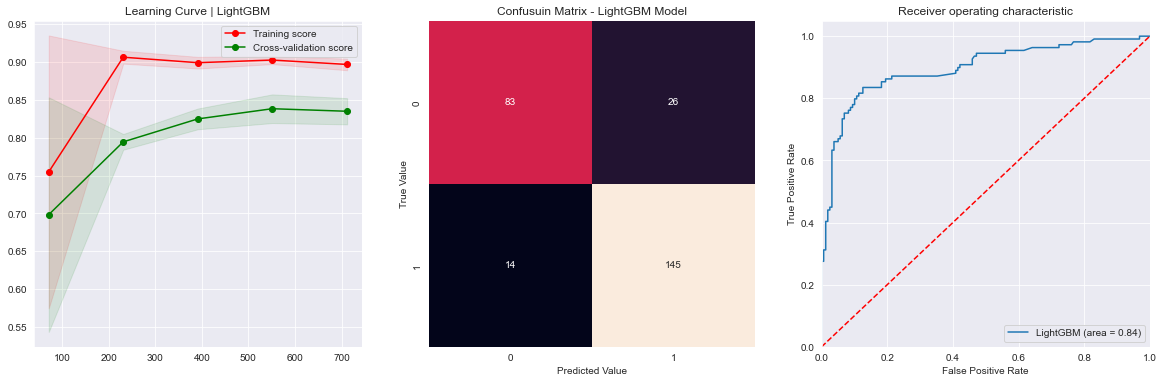

In [206]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(grid.best_estimator_, X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | LightGBM')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - LightGBM Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='LightGBM (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show()

In [20]:
model = LGBMClassifier(boosting_type='dart', extra_trees=False, learning_rate=0.3,
               max_depth=2, min_child_weight=.00001, max_bin=60,
               n_estimators=1000, objective='binary', num_leaves=3, path_smooth=5,
               reg_alpha=0.25, reg_lambda=0.75)

In [25]:
params = {
    'min_child_samples': np.arange(5, 35, 5)
}
grid = GridSearchCV(model, param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END min_child_samples=5;, score=(train=0.902, test=0.909) total time=   1.7s
[CV 2/5] END min_child_samples=5;, score=(train=0.914, test=0.867) total time=   1.0s
[CV 3/5] END min_child_samples=5;, score=(train=0.923, test=0.824) total time=   1.5s
[CV 4/5] END min_child_samples=5;, score=(train=0.937, test=0.782) total time=   1.1s
[CV 5/5] END min_child_samples=5;, score=(train=0.925, test=0.845) total time=   1.1s
[CV 1/5] END min_child_samples=10;, score=(train=0.900, test=0.902) total time=   1.1s
[CV 2/5] END min_child_samples=10;, score=(train=0.919, test=0.860) total time=   1.5s
[CV 3/5] END min_child_samples=10;, score=(train=0.925, test=0.824) total time=   1.0s
[CV 4/5] END min_child_samples=10;, score=(train=0.932, test=0.789) total time=   1.2s
[CV 5/5] END min_child_samples=10;, score=(train=0.921, test=0.838) total time=   1.1s
[CV 1/5] END min_child_samples=15;, score=(train=0.902, test=0.895) total t

In [221]:
# saving this version of model
filename = f'Light GBM v5.0.pkl'
pickle.dump(grid,open(f'{filename}', 'wb'))
print(f'Model {filename} saved successfully!')

Model Light GBM v5.0.pkl saved successfully!


In [73]:
grid = pickle.load(open('Light GBM v5.0.pkl', 'rb'))
grid.best_estimator_

LGBMClassifier(boosting_type='dart', extra_trees=False, learning_rate=0.3,
               max_bin=60, max_depth=2, min_child_samples=30,
               min_child_weight=1e-05, n_estimators=1000, num_leaves=3,
               objective='binary', path_smooth=5, reg_alpha=0.25,
               reg_lambda=0.75)

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       110
         1.0       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



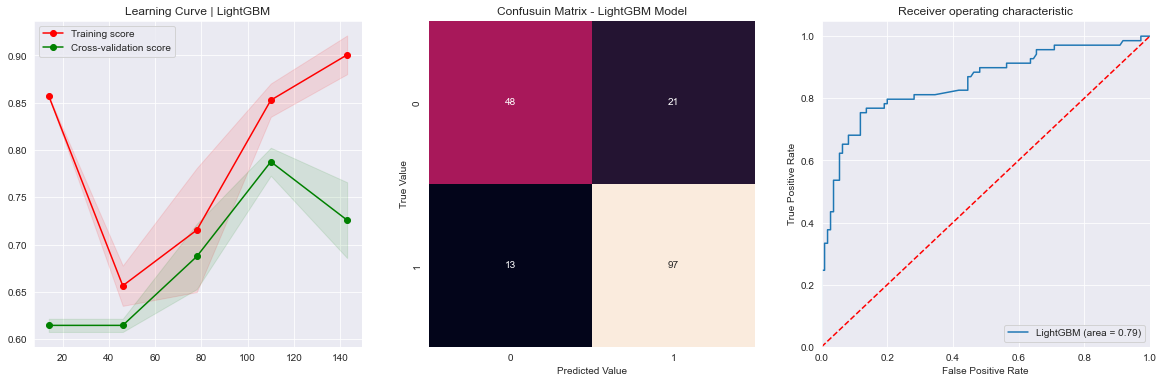

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(grid.best_estimator_, X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | LightGBM')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - LightGBM Model')

logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
axes[2].plot(fpr, tpr, label='LightGBM (area = %0.2f)' % logit_roc_auc)
axes[2].plot([0, 1], [0, 1],'r--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('Receiver operating characteristic')
axes[2].legend(loc="lower right")

plt.show() 

# SGD Classifier

In [72]:
from sklearn.linear_model import SGDClassifier

In [73]:
params = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [.0001, .001, .01, .1],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'early_stopping': [True, False]
}
grid = GridSearchCV(SGDClassifier(), param_grid=params, return_train_score=True, cv=5, verbose=3)
grid.fit(X_train,y_train)
print(f'{grid.best_estimator_} with the accuracy of: {grid.best_score_:.2f}')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[CV 1/5] END alpha=0.0001, early_stopping=True, fit_intercept=True, loss=hinge, penalty=l2, shuffle=True;, score=(train=0.712, test=0.713) total time=   0.0s
[CV 2/5] END alpha=0.0001, early_stopping=True, fit_intercept=True, loss=hinge, penalty=l2, shuffle=True;, score=(train=0.707, test=0.720) total time=   0.0s
[CV 3/5] END alpha=0.0001, early_stopping=True, fit_intercept=True, loss=hinge, penalty=l2, shuffle=True;, score=(train=0.391, test=0.423) total time=   0.0s
[CV 4/5] END alpha=0.0001, early_stopping=True, fit_intercept=True, loss=hinge, penalty=l2, shuffle=True;, score=(train=0.696, test=0.613) total time=   0.0s
[CV 5/5] END alpha=0.0001, early_stopping=True, fit_intercept=True, loss=hinge, penalty=l2, shuffle=True;, score=(train=0.414, test=0.437) total time=   0.0s
[CV 1/5] END alpha=0.0001, early_stopping=True, fit_intercept=True, loss=hinge, penalty=l2, shuffle=False;, score=(train=0.622, test=0.622) total 

              precision    recall  f1-score   support

         0.0       0.83      0.73      0.78       110
         1.0       0.64      0.77      0.70        69

    accuracy                           0.74       179
   macro avg       0.74      0.75      0.74       179
weighted avg       0.76      0.74      0.75       179



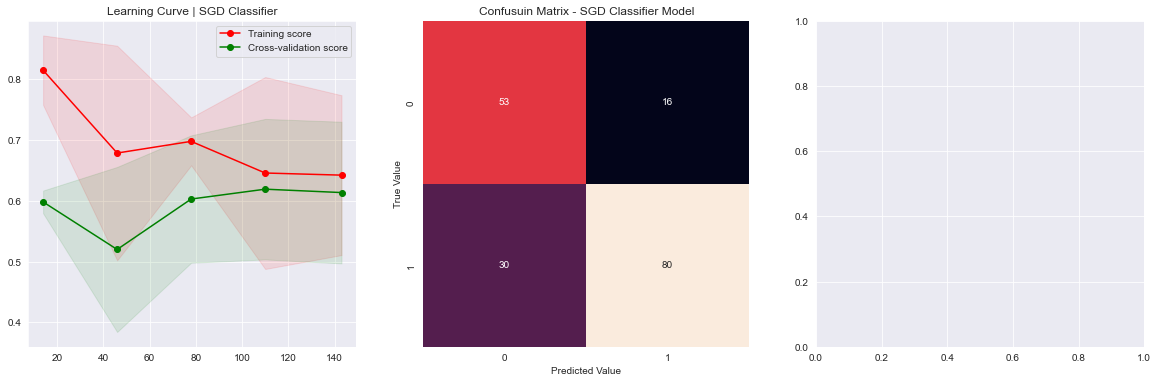

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(20,6))
train_sizes, train_scores, test_scores, = learning_curve(grid.best_estimator_, X_valid, y_valid, train_sizes=np.linspace(.1, 1, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

y_pred = grid.best_estimator_.predict(X_valid)
cls_rep=classification_report(y_valid,y_pred)
print(cls_rep)


axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].legend(loc="best")
axes[0].set_title('Learning Curve | SGD Classifier')

cnf_matrix = confusion_matrix(y_valid, y_pred, labels=[1,0])
sns.heatmap(cnf_matrix, square=True, annot=True, cbar=False, fmt='g', ax=axes[1])
axes[1].set_xlabel('Predicted Value')
axes[1].set_ylabel('True Value')
axes[1].set_title('Confusuin Matrix - SGD Classifier Model')

# logit_roc_auc = roc_auc_score(y_valid, grid.predict(X_valid))
# fpr, tpr, thresholds = roc_curve(y_valid, grid.predict_proba(X_valid)[:,1], pos_label=1)
# axes[2].plot(fpr, tpr, label='SGD Classifier (area = %0.2f)' % logit_roc_auc)
# axes[2].plot([0, 1], [0, 1],'r--')
# axes[2].set_xlim([0.0, 1.0])
# axes[2].set_ylim([0.0, 1.05])
# axes[2].set_xlabel('False Positive Rate')
# axes[2].set_ylabel('True Positive Rate')
# axes[2].set_title('Receiver operating characteristic')
# axes[2].legend(loc="lower right")

plt.show() 